# Forecasting stock prices using RNN (LSTM) vs. CNN

In [118]:
import pandas as pd
import pandas_datareader.data as web
import os
import datetime as dt

from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Flatten
from keras.layers import LSTM, Conv1D, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [119]:
start = dt.datetime(2018, 1, 1)
end = dt.datetime(2020, 7, 3)
df = web.DataReader('^GSPC', 'yahoo', start, end)
df.reset_index(inplace=True)
df = df[['Date', 'Adj Close']]

In [120]:
df.set_index('Date', inplace=True)
df['log_returns'] = np.log(df['Adj Close']) - np.log(df['Adj Close'].shift(1))
df['net_returns'] = np.exp(df['log_returns']) - 1

Text(0, 0.5, 'Closing Prices')

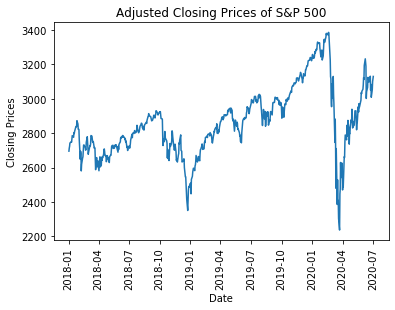

In [121]:
plt.plot(df['Adj Close'])
plt.title('Adjusted Closing Prices of S&P 500')
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Closing Prices')

# Preprocessing

In [122]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    '''
    args:
    - sequence dataframe/array: data
    -n_steps int: number of time steps used to predict
    Function to Preprocess time series data into
    n_steps columns
    
    Credits for function:
    https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
    '''
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [123]:
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(df['Adj Close'], n_steps)

In [124]:
n_data, n_steps = X.shape
n_features = 1

X = X.reshape((n_data, n_steps, n_features))

In [125]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 3 Layer LSTM

In [126]:
n_features = 1
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 3, 50)             10400     
_________________________________________________________________
lstm_23 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [127]:
opt = Adam(learning_rate=0.01,
           epsilon=1e-07)

model.compile(optimizer=opt,
              loss='mse')

In [128]:
callbacks = [
             EarlyStopping(monitor='val_loss',
                           patience=5,
                           min_delta=1e-3,
                           restore_best_weights=True,
                           verbose = 1)
            ]


batch_size = 64
epochs = 100
validation_split = 0.3
verbose = 1 # Print output

# Fit to training Data
history = model.fit(x_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_split = validation_split,
                    callbacks = callbacks,
                    verbose = verbose)

Train on 350 samples, validate on 151 samples
Epoch 1/100
350/350 [==============================] - 1s 3ms/step - loss: 7386624.4771 - val_loss: 4948667.9437
Epoch 2/100
350/350 [==============================] - 0s 291us/step - loss: 2942105.7605 - val_loss: 26050.5580
Epoch 3/100
350/350 [==============================] - 0s 284us/step - loss: 592571.9982 - val_loss: 401976.2454
Epoch 4/100
350/350 [==============================] - 0s 261us/step - loss: 141083.3515 - val_loss: 232870.2583
Epoch 5/100
350/350 [==============================] - 0s 301us/step - loss: 207342.8384 - val_loss: 39014.2132
Epoch 6/100
350/350 [==============================] - 0s 338us/step - loss: 26337.0387 - val_loss: 75289.4637
Epoch 7/100
350/350 [==============================] - 0s 353us/step - loss: 46869.8196 - val_loss: 4797.6557
Epoch 8/100
350/350 [==============================] - 0s 304us/step - loss: 20830.9514 - val_loss: 22249.3925
Epoch 9/100
350/350 [==============================] - 0s 

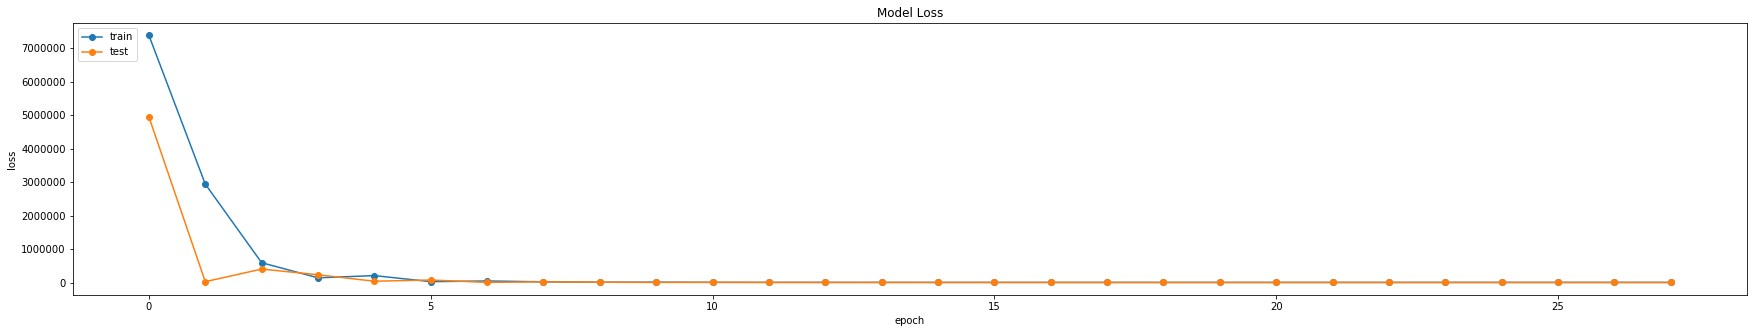

In [129]:
f, ax1 = plt.subplots(1, 1, figsize=(30,5))

# summarize history for loss
ax1.plot(history.history['loss'], marker='o')
ax1.plot(history.history['val_loss'], marker='o')
ax1.set_title('Model Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

In [130]:
model.evaluate(x_test, y_test) # MSE of 4723.95

126/126 [==============================] - 0s 237us/step


1927.2017686631943

# Convolutional Neural Networks

In [131]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(n_steps, n_features)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 3, 64)             128       
_________________________________________________________________
batch_normalization_6 (Batch (None, 3, 64)             256       
_________________________________________________________________
flatten_7 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                12352     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 12,801
Trainable params: 12,673
Non-trainable params: 128
_________________________________________________________________


In [132]:
opt = Adam(learning_rate=0.01,
           epsilon=1e-07)

model.compile(optimizer=opt,
              loss='mse')

In [133]:
callbacks = [
             EarlyStopping(monitor='val_loss',
                           patience=5,
                           min_delta=1e-3,
                           restore_best_weights=True,
                           verbose = 1)
            ]


batch_size = 64
epochs = 100
validation_split = 0.3
verbose = 1 # Print output

# Fit to training Data
history = model.fit(x_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_split = validation_split,
                    callbacks = callbacks,
                    verbose = verbose)

Train on 350 samples, validate on 151 samples
Epoch 1/100
350/350 [==============================] - 0s 1ms/step - loss: 8262153.2171 - val_loss: 1585320.8957
Epoch 2/100
350/350 [==============================] - 0s 122us/step - loss: 8128672.6343 - val_loss: 42781.4368
Epoch 3/100
350/350 [==============================] - 0s 137us/step - loss: 7881754.7857 - val_loss: 4016244.1805
Epoch 4/100
350/350 [==============================] - 0s 124us/step - loss: 7466656.9857 - val_loss: 17837154.1192
Epoch 5/100
350/350 [==============================] - 0s 134us/step - loss: 6835812.1200 - val_loss: 54915598.5695
Epoch 6/100
350/350 [==============================] - 0s 125us/step - loss: 5934171.9229 - val_loss: 126413602.2252
Epoch 7/100
350/350 [==============================] - 0s 134us/step - loss: 4762381.5700 - val_loss: 241864009.5364
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping


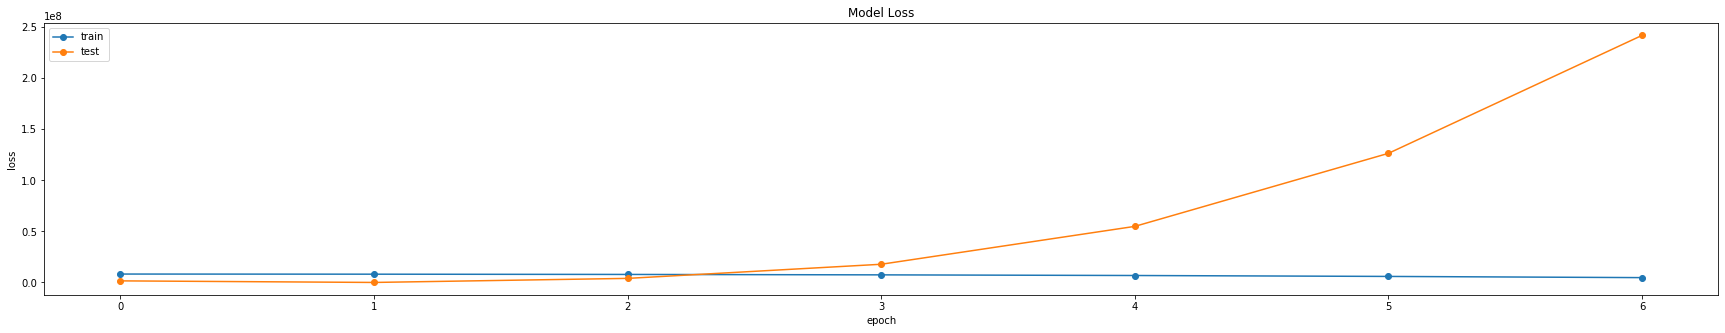

In [134]:
f, ax1 = plt.subplots(1, 1, figsize=(30,5))

# summarize history for loss
ax1.plot(history.history['loss'], marker='o')
ax1.plot(history.history['val_loss'], marker='o')
ax1.set_title('Model Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

In [135]:
model.evaluate(x_test, y_test) # MSE of 4723.95

126/126 [==============================] - 0s 95us/step


42500.16393849206

As expected, RNN models such as a LSTM would be much more effective in forecasting time series data / Stock Prices than a Convolutional Neural Network